# Plot chemotaxis results
Gets the results of automated image analysis for the Neuroplant project, calculates chemotaxis index, and plots the results.

Todo:
- add estimation plots for each compound

In [1]:
import time
start = time.time()
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pathlib
import warnings
import seaborn as sns
import dabest
# import pydrive

### Specify data location

In [2]:
base_folder = pathlib.Path('/Users/adam/Documents/Neuroplant/')
automated_analysis_data_folder = base_folder.joinpath('automated_analysis_results')

### Load the metadata from the experiments

In [3]:
assay_metadata = pd.read_csv(base_folder.joinpath(
    'Neuroplant Chemotaxis Assay Responses - Form Responses 1.csv'))
assay_metadata.rename(columns={'Plate ID (example NPP001):': 'plate_id',
                               'CompoundDecode': 'compound',
                               'Decode in Well P:': 'well_P_strain',
                               'Decode in Well Q:': 'well_Q_strain',
                               'Decode in Well R:': 'well_R_strain',
                               'Decode in Well S:': 'well_S_strain'}, inplace=True)

### Load summary data from automated results

In [4]:
automated_analysis_results = []
for file in automated_analysis_data_folder.glob('NPP*_chemotaxis_summary.csv'):
    this_file_results = pd.read_csv(file)
    this_file_results.rename(columns={'Plate_id': 'plate_id',
                                      'Well_id': 'well_id'}, inplace=True)
    automated_analysis_results.append(this_file_results)
automated_analysis_results = pd.concat(automated_analysis_results)

def add_strain_name(row, assay_metadata):
    strain = assay_metadata.loc[
        assay_metadata['plate_id']==row['plate_id']][
        'well_'+row['well_id']+'_strain']
    return strain.values[0]

def add_compound(row, assay_metadata):
    compound = assay_metadata.loc[
        assay_metadata['plate_id']==row['plate_id']]['compound']
    return compound.values[0]

def get_worm_count_from_auto_analysis(row):
    this_well_results = pd.read_csv(row['results_file'])
    return this_well_results.shape[0]

automated_analysis_results['strain'] = automated_analysis_results.apply(
    lambda row: add_strain_name(row, assay_metadata), axis=1).astype('category')
automated_analysis_results['compound'] = automated_analysis_results.apply(
    lambda row: add_compound(row, assay_metadata), axis=1).astype('category')
automated_analysis_results['analysis_method'] = 'automated'
automated_analysis_results['total_worms'] = automated_analysis_results.apply(
    lambda row: get_worm_count_from_auto_analysis(row), axis=1)

## Plot results

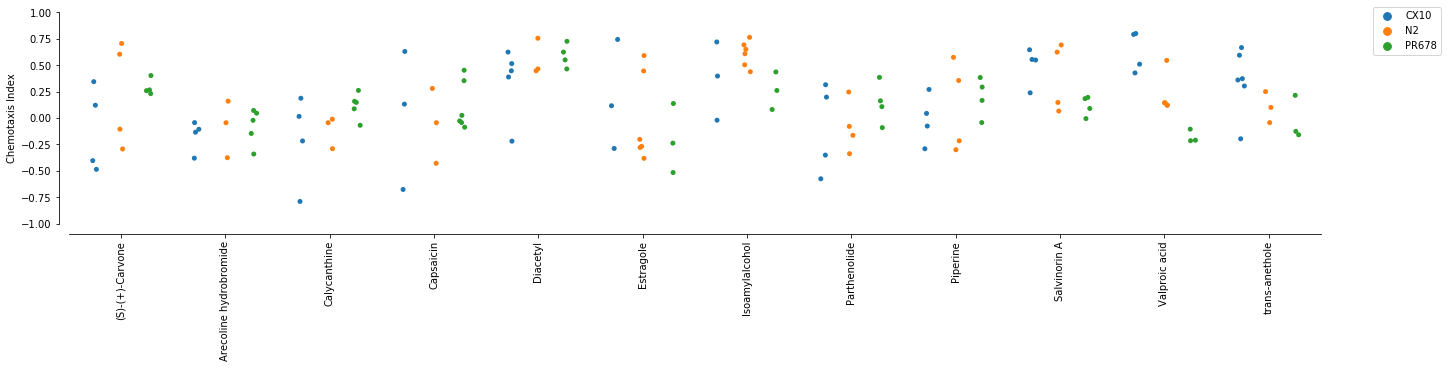

In [5]:
fig, ax = plt.subplots(figsize=(20, 5), constrained_layout=True)
sns.stripplot(x='compound', y='chemotaxis_index', ax=ax, dodge=True, #style='analysis_method',
              hue='strain', marker='o',
              data=automated_analysis_results)

ax.set_xlabel('')
ax.set_ylabel('Chemotaxis Index')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylim((-1, 1))
sns.despine(offset=10)
plt.xticks(rotation=90)

fig.savefig('../chemotaxis_results_automated.pdf')

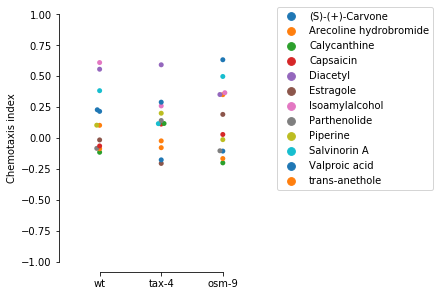

In [6]:
fig, ax = plt.subplots(constrained_layout=True)

sns.swarmplot(x='strain', y='chemotaxis_index', hue='compound', palette='tab10',
                   order=['N2', 'PR678', 'CX10'], ax=ax,
                   data=automated_analysis_results.groupby(
                           ['strain', 'compound']).mean().reset_index())
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xticklabels(['wt', 'tax-4', 'osm-9'])
ax.set_xlabel('')
ax.set_ylabel('Chemotaxis index')
ax.set_ylim((-1, 1))
sns.despine(offset=10, trim=True)

# fig.savefig(base_folder.joinpath('CI_by_strain_and_compound.pdf'))

/miniconda2/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


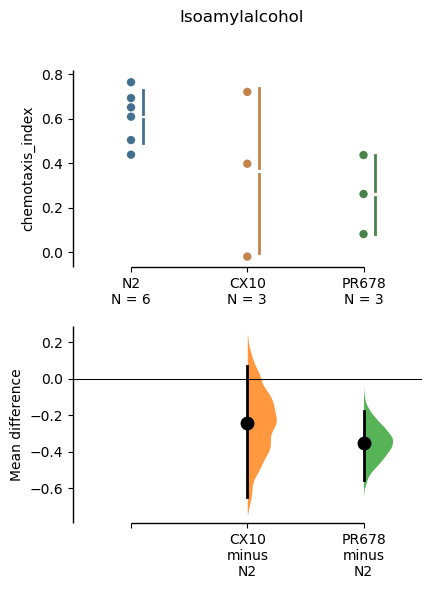

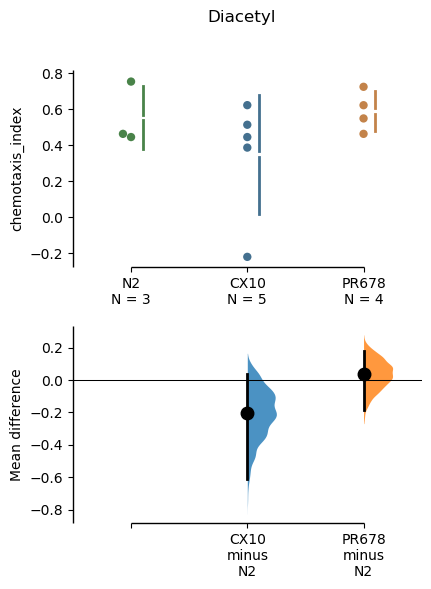

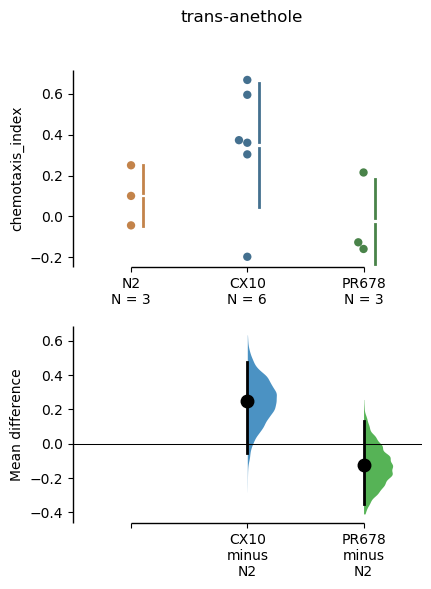

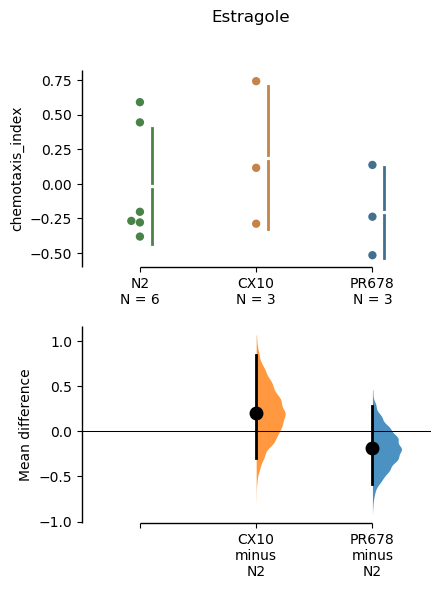

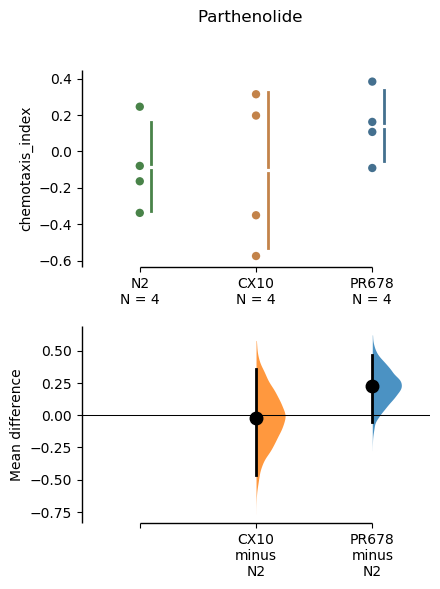

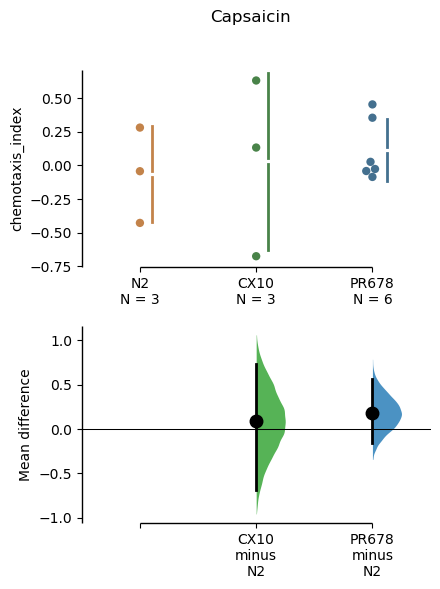

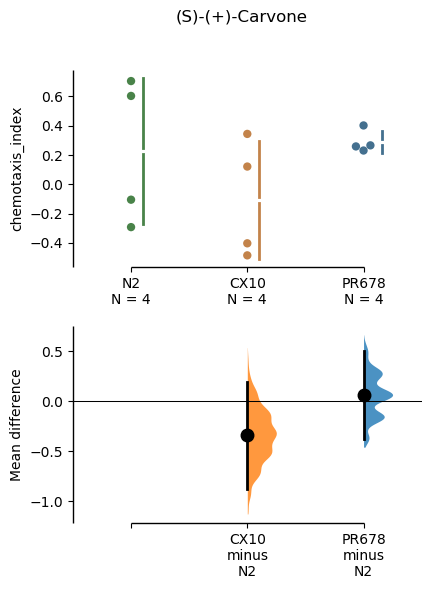

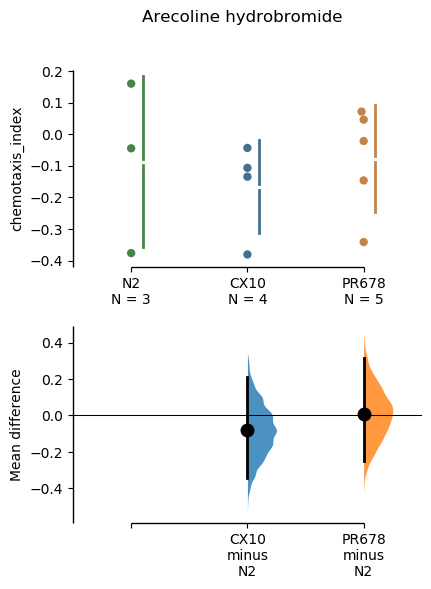

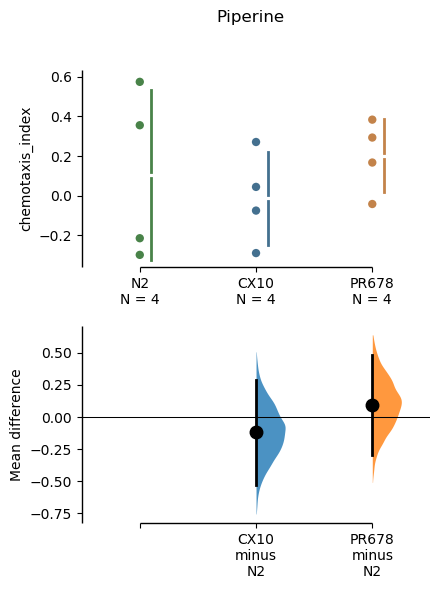

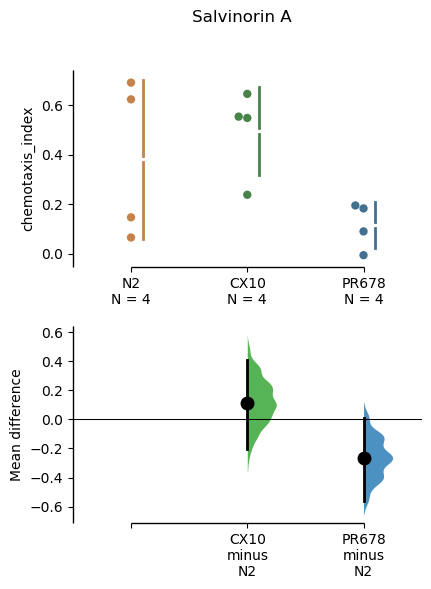

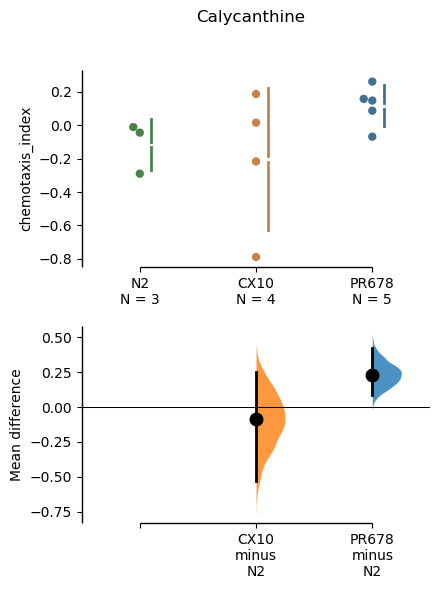

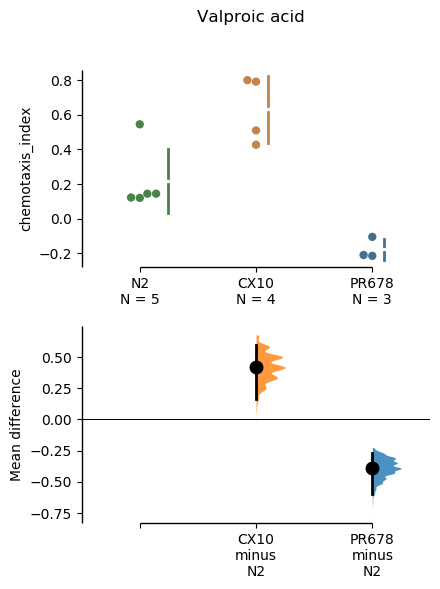

In [7]:
for compound in automated_analysis_results['compound'].unique():
    this_compound_data = dabest.load(
        data=automated_analysis_results.loc[automated_analysis_results['compound']==compound],
        x='strain', y='chemotaxis_index', idx=automated_analysis_results['strain'].unique())
    this_fig = this_compound_data.mean_diff.plot()
    this_fig.suptitle(compound)

In [8]:
print('Notebook ran in', int(time.time()-start), 'seconds.')

Notebook ran in 25 seconds.
